# load atoms

In [22]:
from scipy.io import loadmat
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt


In [30]:
import sys
print(sys.version)

'''
lspci | grep -i nvidia
0000:18:00.0 VGA compatible controller: NVIDIA Corporation GA102GL [RTX A5000] (rev a1)
0000:18:00.1 Audio device: NVIDIA Corporation GA102 High Definition Audio Controller (rev a1)


nvidia-smi:
Driver Version: 470.129.06   CUDA Version: 11.4

tensorflow requirest driver 525.60.13

uname -r  # kernel version:
4.18.0-425.13.1.el8_7.x86_64



nvcc --version
Built on Thu_Sep_12_02:18:05_PDT_2024
Cuda compilation tools, release 12.6, V12.6.77
Build cuda_12.6.r12.6/compiler.34841621_0

'''

3.12.7 | packaged by conda-forge | (main, Oct  4 2024, 16:05:46) [GCC 13.3.0]


79 /mnt/megshare/Development/Sheng/__dump/20241126_aes_poster_figures/WHOLE_COHORT_ATOMS_30x3s_1-30Hz/case_0324_1_set02_BB_1-30Hz_30_Atoms_3(s)_NormParcTS(True).mat
dict_keys(['__header__', '__version__', '__globals__', 'u_hat', 'v_hat', 'z_hat', 'fs'])


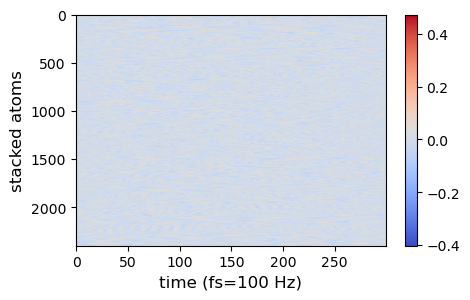

In [24]:
RESULT_DIR = Path('/mnt/megshare/Development/Sheng/__dump/20241126_aes_poster_figures/WHOLE_COHORT_ATOMS_30x3s_1-30Hz')
CDL_RESULTS = [matfile for matfile in RESULT_DIR.glob("*.mat") ]

################## HARD CODE atom database dimension !!!!!!
ATOM_per_SUBJ = 30
U_HAT = np.zeros([ATOM_per_SUBJ * len(CDL_RESULTS), 300])


print(i, iSession)
for i, iSession in enumerate(CDL_RESULTS):
    data             = loadmat(iSession)  
    U_HAT[i*ATOM_per_SUBJ:(i+1)*ATOM_per_SUBJ, :] = data['v_hat']
    #print(i, iSession.stem)


data = loadmat(iSession)
print(data.keys())


# First try with autoencoder

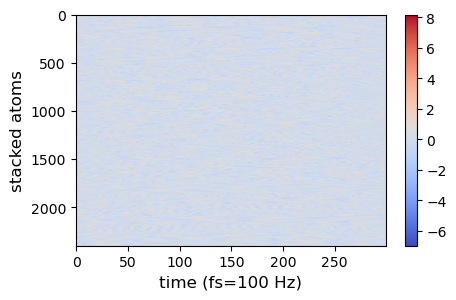

In [26]:
# normalize and reshape the data for input into a CNN or U-Net model. For a 1D CNN, add a channel dimension:
data_normalized = (U_HAT - U_HAT.mean(axis=1, keepdims=True)) / U_HAT.std(axis=1, keepdims=True)
data_reshaped = data_normalized[..., np.newaxis]  # Shape: (1800, 300, 1)


plt.figure(figsize=(5, 3))
plt.imshow(data_normalized, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.xlabel('time (fs=100 Hz)', fontsize=12)
plt.ylabel('stacked atoms', fontsize=12)
plt.show()

Feature Extraction with CNN/U-Net

In [28]:
'''



Use a 1D CNN or a U-Net to extract features from the waveforms. 
The goal is to learn a low-dimensional representation of the signals
that can capture shape and frequency characteristics.
'''

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Dense

# Input layer
input_signal = Input(shape=(300, 1))

# Encoder
x = Conv1D(32, 3, activation='relu', padding='same')(input_signal)
x = MaxPooling1D(2, padding='same')(x)
x = Conv1D(64, 3, activation='relu', padding='same')(x)
encoded = MaxPooling1D(2, padding='same')(x)

# Decoder
x = Conv1D(64, 3, activation='relu', padding='same')(encoded)
x = UpSampling1D(2)(x)
x = Conv1D(32, 3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(x)

# Autoencoder model
autoencoder = Model(input_signal, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(data_reshaped, data_reshaped, epochs=50, batch_size=32, shuffle=True)


InternalError: cudaGetDevice() failed. Status: CUDA driver version is insufficient for CUDA runtime version

In [ ]:
# Extract the features from the encoder output for clustering:
encoder = Model(inputs=autoencoder.input, outputs=encoded)
features = encoder.predict(data_reshaped)  # Shape: (1800, latent_dim)

In [ ]:
# cluster the features

from sklearn.cluster import KMeans

# Reshape features for clustering if needed
flat_features = features.reshape(features.shape[0], -1)  # Flatten the features

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(flat_features)

# Visualize the clusters
import matplotlib.pyplot as plt
plt.scatter(flat_features[:, 0], flat_features[:, 1], c=labels, cmap='viridis')
plt.title('Cluster Visualization')
plt.show()


In [ ]:
# evaluate clusters
from sklearn.metrics import silhouette_score

score = silhouette_score(flat_features, labels)
print(f"Silhouette Score: {score}")


# Option 2: U-Net for Shape-Based Clustering

In [ ]:
from tensorflow.keras.layers import Conv1DTranspose, concatenate

# Encoder
x = Conv1D(32, 3, activation='relu', padding='same')(input_signal)
x = MaxPooling1D(2, padding='same')(x)
x = Conv1D(64, 3, activation='relu', padding='same')(x)
encoded = MaxPooling1D(2, padding='same')(x)

# Decoder
x = Conv1DTranspose(64, 3, activation='relu', padding='same')(encoded)
x = UpSampling1D(2)(x)
x = Conv1DTranspose(32, 3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(x)

# U-Net model
unet = Model(input_signal, decoded)
unet.compile(optimizer='adam', loss='mse')

# Train the U-Net
unet.fit(data_reshaped, data_reshaped, epochs=50, batch_size=32, shuffle=True)

# Extract learned features from the encoder part of the U-Net and proceed with clustering as before.